In [71]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.io import ascii
from astropy.coordinates import Angle, EarthLocation, AltAz, SkyCoord
from astropy.time import Time

In [89]:
MMT_LOCATION = EarthLocation.from_geodetic("-110:53:04.4", "31:41:19.6", 2600 * u.m)
obstime = Time("2021-08-21T06:00:00", format='isot')

# don't strictly need time or location for our purposes, but astropy wants them for defining the alt/az frame
aa_frame = AltAz(obstime=obstime, location=MMT_LOCATION)

def tpoint(coo, ia, ie, an, aw, ca, npae, tf, tx):
    """
    Apply 8-term alt-az tpoint model to set of raw alt-az coordinates and return corrected coordinates
    """
    da = -1 * ia
    da -= an * np.sin(coo.az) * np.tan(coo.alt)
    da -= aw * np.cos(coo.az) * np.tan(coo.alt)
    da -= ca / np.cos(coo.alt)
    da -= npae * np.tan(coo.alt)

    de = ie
    de -= an * np.cos(coo.az)
    de += aw * np.sin(coo.az)
    de -= tf * np.cos(coo.alt)
    de -= tx / np.tan(coo.alt)

    new_az = coo.az + da * u.arcsec
    new_alt = coo.alt + de * u.arcsec

    new_coo = SkyCoord(new_az, new_alt, frame=aa_frame)
    return new_coo

def skyrms(coo_ref, coo_meas):
    """
    Calculate sky RMS of the offsets between reference and measured coordinates in the same way as tpoint.
    Return the result in arcseconds.
    """
    sep = coo_ref.separation(coo_meas)
    rms = np.sqrt((sep ** 2).mean()).to(u.arcsec)
    return rms

def psd(coo_ref, coo_meas, nterms=8):
    """
    Calculate the population standard deviation, PSD, the way tpoint does. Returh the result in arcseconds. 
    """
    rms = skyrms(coo_ref, coo_meas)
    sd = np.sqrt(rms**2 * len(coo_meas) / (len(coo_meas) - nterms))
    return sd

In [30]:
datafile = "point_tweak.dat"
t = ascii.read(datafile, data_start=20, format='no_header', guess=False, fast_reader=False)
az_obs = Angle(t['col1'], unit=u.degree).wrap_at(360 * u.deg)
el_obs = Angle(t['col2'], unit=u.degree).wrap_at(360 * u.deg)
az_raw = Angle(t['col3'], unit=u.degree).wrap_at(360 * u.deg)
el_raw = Angle(t['col4'], unit=u.degree).wrap_at(360 * u.deg)
coo_obs = SkyCoord(az_obs, el_obs, frame=aa_frame)
coo_raw = SkyCoord(az_raw, el_raw, frame=aa_frame)

In [42]:
coo_obs.separation(coo_raw).std().to(u.arcsec)

<Angle 321.7543166 arcsec>

In [84]:
t_coo = tpoint(coo_raw, 1212.01, -2.99, 2.51, -10.34, -10.10, 0.0, 21.41, -2.71)
seps = coo_obs.separation(t_coo)
np.median(seps.to(u.arcsec))

<Angle 0.73505297 arcsec>

In [61]:
az_res, el_res = coo_obs.spherical_offsets_to(t_coo)

In [68]:
np.sqrt((az_res **2 + el_res ** 2)).mean().to(u.arcsec)

<Quantity 0.84261286 arcsec>

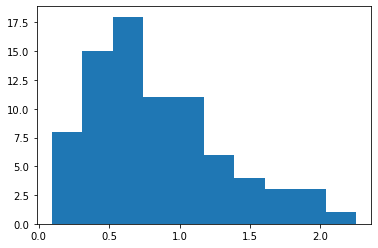

In [79]:
plt.hist(seps.to(u.arcsec).value)
plt.show()

In [91]:
skyrms(coo_obs, t_coo)

<Quantity 0.96236609 arcsec>

In [92]:
psd(coo_obs, t_coo)

<Quantity 1.01442293 arcsec>